# Librairies

In [2]:
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

c:\Users\lataw\anaconda3\envs\vectorization\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [3]:

# Load IMDb dataset
raw = load_dataset("imdb")

# Combine train + test into a single dataset (50k rows)
all_data = concatenate_datasets([raw["train"], raw["test"]])
texts = all_data['text']
print(len(all_data))  # 50000
print(all_data[0]['text'])

50000
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

## stritified k-folds

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
y      = np.array(all_data['label'])
_, idx_1k = next(sss.split(texts, y))
texts_1k = np.array(texts)[idx_1k]
y_1k     = y[idx_1k]

In [5]:

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(y_1k)), y_1k))

## Text length distribution

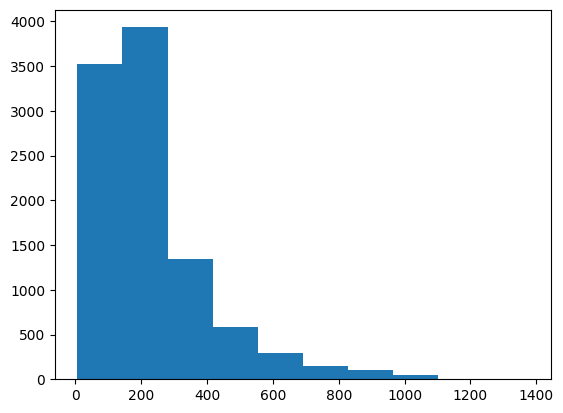

In [6]:
lengths_data = [len(t.split()) for t in texts_1k]

plt.hist(lengths_data)
plt.show()

# CLeaning

In [7]:
import re, html, unicodedata

_WS        = re.compile(r"\s+")
_HTML_TAG  = re.compile(r"<[^>]+>")
_BR        = re.compile(r"<br\s*/?>", flags=re.I)
_RATING    = re.compile(r"\b\d{1,2}\s*/\s*10\b")  # e.g. 8/10, 10/10

def minimal_clean(text: str, max_words: int = 800) -> str:
    t = unicodedata.normalize("NFKC", str(text))  # unicode normalize
    t = html.unescape(t)                          # decode &amp; etc.
    t = _BR.sub(" ", t)                           # <br> -> space
    t = _HTML_TAG.sub(" ", t)                     # drop other tags
    t = _RATING.sub(" ", t)                       # remove 8/10 leaks
    t = _WS.sub(" ", t).strip()  
   
    return t

## Transformers model

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel


#device ='cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "sentence-transformers/all-MiniLM-L6-v2"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder   = AutoModel.from_pretrained(model_name).to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class TransformersEmbedder(nn.Module):
    def __init__(self, tokenizer, encoder, device,batch_size: int = 64,max_length=512,stride:int=128, chunck_batch = 16):
        super().__init__()
        self.tokenizer =  tokenizer
        self.encoder  = encoder.eval()
        self.device = device
        self.batch_size = batch_size
        self.max_length = max_length
        self.stride = stride
        self.chunck_batch = chunck_batch


    def forward(self, texts):
        
        embs = []
        
        with torch.no_grad():
            for t in texts:
                
                encoded = self.tokenizer(
                    t,
                    truncation=True,
                    stride = self.stride,
                    return_tensors="pt",
                    return_overflowing_tokens=True,
                    max_length = self.max_length,
                    padding=True
                ).to(self.device)

                input_ids, attention = encoded['input_ids'] , encoded['attention_mask']
                chunks_vect = []
                token_counts = []
                for j in range(0,input_ids.size()[0],self.chunck_batch):
                    ids_b = input_ids[j:j+self.chunck_batch]
                    attn_b =  attention[j:j+self.chunck_batch]
                    output = self.encoder(input_ids=ids_b, attention_mask=attn_b)
                    embeddings = mean_pooling(output, attn_b)
                    #embeddings = F.normalize(embeddings, p=2, dim=1)
                    chunks_vect.append(embeddings.cpu().numpy().astype(np.float32))
                    token_counts.append(attn_b.sum(dim=1).cpu().numpy().astype(np.float32))
                chunks_vect = np.vstack(chunks_vect).astype(np.float32)
                token_counts = np.concatenate(token_counts).astype(np.float32)  # (C,

                w = token_counts / (token_counts.sum() + 1e-9)     # weights
                doc = (chunks_vect * w[:, None]).sum(axis=0)
                embs.append(doc / (np.linalg.norm(doc) + 1e-9))
        return np.vstack(embs)  # shape: (B, h,p=idden_size)
    

model = TransformersEmbedder(tokenizer, encoder, device)

In [9]:
All_mini_vectors = model([minimal_clean(t) for t in list(texts_1k)])

# Static vector

In [10]:

def minimal_clean(text: str, max_words: int = 800) -> str:
    t = unicodedata.normalize("NFKC", str(text))  # unicode normalize
    t = html.unescape(t)                          # decode &amp; etc.
    t = _BR.sub(" ", t)                           # <br> -> space
    t = _HTML_TAG.sub(" ", t)                     # drop other tags
    t = _RATING.sub(" ", t)                       # remove 8/10 leaks
    t = _WS.sub(" ", t).strip()
    t = t.lower()  
   
    return t

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


class TfidfEmbedder:
    def __init__(self,
                 analyzer="word",
                 ngram_range=(1,2),
                 min_df=2,
                 max_df=0.9,
                 sublinear_tf=True,
                 norm="l2"):
        self.vec = TfidfVectorizer(analyzer=analyzer,
                                   ngram_range=ngram_range,
                                   min_df=min_df, max_df=max_df,
                                   sublinear_tf=sublinear_tf,
                                   norm=norm,
                                   preprocessor=minimal_clean)
    def fit(self, texts):
        self.vec.fit(texts)
        return self
    def transform(self, texts):
        return self.vec.transform(texts)
    




# Training and score computation

In [12]:
from sklearn.metrics import accuracy_score, f1_score

correct_A_list = []
correct_B_list =  []
length_text = []
accuracies_A = []
accuracies_B = []
for fold, (tr,te) in enumerate(skf.split(np.zeros(len(y_1k)), y_1k)):
    tr_transformers = All_mini_vectors[tr]
    te_transformers = All_mini_vectors[te]
    
   
    y_test = y_1k[te]

    tr = list(tr)
    te = list(te)

    tf_embed = TfidfEmbedder()
    tf_vector_train = tf_embed.vec.fit_transform(texts_1k[tr])
    tf_vector_test = tf_embed.transform(texts_1k[te])
    


    model_A = LogisticRegression(max_iter=2000,solver="lbfgs").fit(tr_transformers,y_1k[tr])
    model_B =  LogisticRegression(max_iter=2000,solver="liblinear").fit(tf_vector_train,y_1k[tr])

    y_hat_A =  model_A.predict(te_transformers)
    y_hat_B = model_B.predict(tf_vector_test)
    
    correct_A = (y_hat_A == y_test)
    correct_B = (y_hat_B == y_test)

    correct_A_list.append(correct_A)
    correct_B_list.append(correct_B)
    length_text.append([len(minimal_clean(texts_1k[i].split())) for i in te])


    accuracies_A.append(accuracy_score(y_test,y_hat_A))

    accuracies_B.append(accuracy_score(y_test,y_hat_B))







In [13]:
accuracies_A = np.array(accuracies_A)
accuracies_B = np.array(accuracies_B)

correct_A = np.concatenate(correct_A_list).astype(int)   # shape (N,)
correct_B = np.concatenate(correct_B_list).astype(int)   # shape (N,)
lengths   = np.array([L for fold_L in length_text for L in fold_L], dtype=int)  # shape (N,)

## Results per folds

In [14]:
import random
from statistics import mean

def paired_perm_folds(acc_A, acc_B, n_perm=10000, seed=42):
    rng = np.random.default_rng(seed)
    d = np.asarray(acc_A, float) - np.asarray(acc_B, float)  # paired diffs per fold
    delta_obs = d.mean()
    k = d.size
    diffs = np.empty(n_perm, float)
    for i in range(n_perm):
        sign = np.where(rng.random(k) < 0.5, 1.0, -1.0)      # flip each pair with p=0.5
        diffs[i] = (sign * d).mean()
    p = (np.sum(np.abs(diffs)>= abs(delta_obs))+1) / (n_perm+1)  # two-sided
    return float(delta_obs), float(p), diffs


obs, p, diffs = paired_perm_folds(accuracies_A,accuracies_B)

print(f"p_value : {p}")



p_value : 9.999000099990002e-05


## Results per instance

In [15]:
def paired_perm_instance(correct_A, correct_B, n_perm=10000, seed=42):
    rng = np.random.default_rng(seed)
    A = np.asarray(correct_A, int); B = np.asarray(correct_B, int)
    delta_obs = A.mean() - B.mean()
    N = A.size
    diffs = np.empty(n_perm, float)
    for i in range(n_perm):
        swap = rng.random(N) < 0.5
        A_p = np.where(swap, B, A)
        B_p = np.where(swap, A, B)
        diffs[i] = A_p.mean() - B_p.mean()
    p = (np.sum(np.abs(diffs) >= abs(delta_obs)) + 1) / (n_perm + 1)
    return float(delta_obs), float(p),diffs
obs, p, diffs = paired_perm_instance(correct_A,correct_B)

print(f"p_value : {p}")

p_value : 9.999000099990002e-05


In [17]:
def paired_perm_instance(correct_A, correct_B, n_perm=1000000, seed=42):
    rng = np.random.default_rng(seed)
    A = np.asarray(correct_A, int); B = np.asarray(correct_B, int)
    delta_obs = A.mean() - B.mean()
    N = A.size
    diffs = np.empty(n_perm, float)
    for i in range(n_perm):
        swap = rng.random(N) < 0.5
        A_p = np.where(swap, B, A)
        B_p = np.where(swap, A, B)
        diffs[i] = A_p.mean() - B_p.mean()
    p = (np.sum(np.abs(diffs) >= abs(delta_obs)) + 1) / (n_perm + 1)
    return float(delta_obs), float(p),diffs
obs, p, diffs = paired_perm_instance(correct_A,correct_B)

print(f"p_value : {p}")

p_value : 9.99999000001e-07


## Boostrap CI

In [18]:
def bootstrap_ci_diff(correct_A, correct_B, B=100000, seed=42):
    import numpy as np
    rng = np.random.default_rng(seed)
    N = len(correct_A)
    deltas = np.empty(B, float)
    A = np.asarray(correct_A, int); Bv = np.asarray(correct_B, int)
    for i in range(B):
        idx = rng.integers(0, N, size=N)
        deltas[i] = A[idx].mean() - Bv[idx].mean()
    return float(np.quantile(deltas, 0.025)), float(np.quantile(deltas, 0.975))


end_min,end_max = bootstrap_ci_diff(correct_A, correct_B, B=100000, seed=0)

## Vizualization

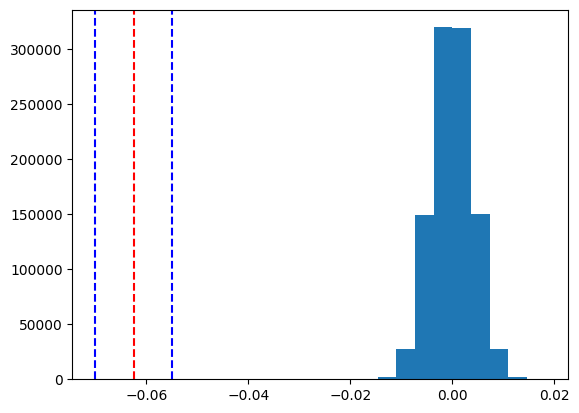

In [19]:
plt.hist(diffs)
plt.axvline(x=obs, color='r', linestyle='--', label ='observed difference')
plt.axvline(x=end_min, color='b', linestyle='--', label ='min')
plt.axvline(x=end_max, color='b', linestyle='--', label ='max')

## Analysis by text length

In [20]:
q1, q2 = np.quantile(lengths, [1/3, 2/3])
bins = np.digitize(lengths, [q1, q2])   # 0=short, 1=medium, 2=long

for b, name in enumerate(["short", "medium", "long"]):
    idx = (bins == b)
    n = int(idx.sum())
    if n < 20:
        print(f"{name}: too few samples (n={n})"); 
        continue

    acc_A = float(correct_A[idx].mean())
    acc_B = float(correct_B[idx].mean())
    obs,p, diffs = paired_perm_instance(correct_A[idx], correct_B[idx], n_perm=10000, seed=123)

    print(f"{name:<6} | n={n:4d} | acc_A={acc_A:.3f} acc_B={acc_B:.3f} | Δ={obs:+.3f} | p_perm={p:.3f}")

short  | n=3329 | acc_A=0.838 acc_B=0.894 | Δ=-0.056 | p_perm=0.000
medium | n=3336 | acc_A=0.819 acc_B=0.878 | Δ=-0.059 | p_perm=0.000
long   | n=3335 | acc_A=0.817 acc_B=0.890 | Δ=-0.073 | p_perm=0.000


# Power study

In [22]:
P11 = np.where((correct_A==1)& (correct_B==1),1,0).sum()/len(correct_A)
P00 = np.where((correct_A==0)& (correct_B==0),1,0).sum()/len(correct_A)
P10 = np.where((correct_A==1)& (correct_B==0),1,0).sum()/len(correct_A)
P01 = np.where((correct_A==0)& (correct_B==1),1,0).sum()/len(correct_A)

In [23]:

pvals = [P11,P00,P10,P01]


<BarContainer object of 4 artists>

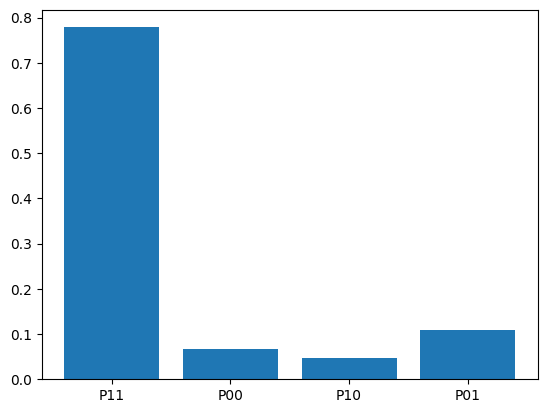

In [25]:
plt.bar(['P11','P00','P10','P01'],pvals)

## Calibration

In [26]:
P_cal = (P10+P01)/2
pvals_calibration = [P11,P00,P_cal,P_cal]

In [ ]:
def calibration_from_multinomial(N_list, pvals, M=1000, n_perm=10000, alpha=0.05, seed=0):
  
    
    rng = np.random.default_rng(seed)
    mapping = np.array([[1,1],[0,0],[1,0],[0,1]], dtype=int)

    out = []
    for N in N_list:
        rej = 0
        for _ in range(M):
            states = rng.choice(4, size=N, p=pvals)
            pairs  = mapping[states]           
            A, B = pairs[:,0], pairs[:,1]
            _, p, _ = paired_perm_instance(A, B,n_perm=n_perm)
            rej += (p <= alpha)
        false_p = rej / M
        se = (false_p * (1 - false_p) / M) ** 0.5 
        out.append((N, false_p, se))
    return out

results_calibration = calibration_from_multinomial([50,100,300,400,500,700,1000,1000,1500,2000,5000,10000],pvals_calibration)

In [28]:
N_arr = np.array([cal[0] for cal in results_calibration])
false_p = np.array([cal[1] for cal in results_calibration])
SE_arr = np.array([cal[2] for cal in results_calibration])

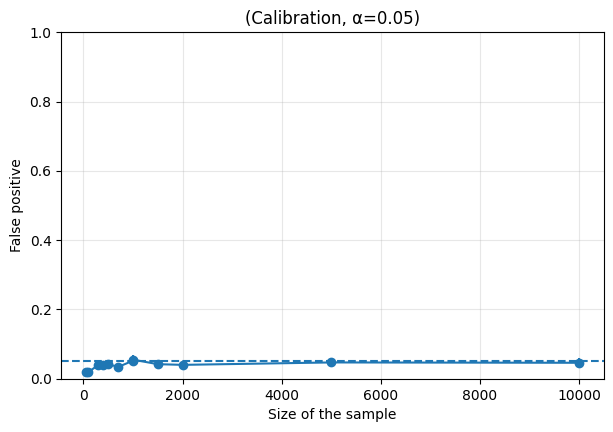

In [29]:
plt.figure(figsize=(7,4.5))
# Barres d'erreur = IC95% Monte-Carlo (±1.96*SE)
plt.errorbar(N_arr, false_p, yerr=1.96*SE_arr, fmt='o-')
plt.axhline(0.05, linestyle='--')  # repère 80%
plt.ylim(0, 1)
plt.xlabel("Size of the sample")
plt.ylabel("False positive")

title = f"(Calibration, α={str(0.05)})"
plt.title(title)
plt.grid(True, alpha=0.3)
plt.show()

## Analysis

In [ ]:
def power_from_multinomial(N_list, pvals, M=1000, n_perm=10000, alpha=0.05, seed=0):
  
    rng = np.random.default_rng(seed)
    mapping = np.array([[1,1],[0,0],[1,0],[0,1]], dtype=int)

    out = []
    for N in N_list:
        rej = 0
        for _ in range(M):
            # tirer les états directement (catégorielle)
            states = rng.choice(4, size=N, p=pvals)
            pairs  = mapping[states]             # shape (N,2)
            A, B = pairs[:,0], pairs[:,1]
            _, p, _ = paired_perm_instance(A, B,n_perm=n_perm)
            rej += (p <= alpha)
        power_hat = rej / M
        se = (power_hat * (1 - power_hat) / M) ** 0.5  # erreur MC (proportion)
        out.append((N, power_hat, se))
    return out

results_power = power_from_multinomial([50,100,300,400,500,700,1000,1000,1500,2000,5000,10000],pvals)

In [37]:
N_arr = np.array([power[0] for power in results_power])
power_arr = np.array([power[1] for power in results_power])
SE_arr = np.array([power[2] for power in results_power])



In [160]:
results_power

[(50, 0.104, 0.009653186002558949),
 (100, 0.272, 0.014071815803228808),
 (300, 0.744, 0.013800869537822608),
 (400, 0.885, 0.010088359628799917),
 (500, 0.951, 0.006826346021115546),
 (700, 0.992, 0.0028170906978654425),
 (1000, 0.999, 0.0009994998749374613),
 (1000, 1.0, 0.0),
 (1500, 1.0, 0.0),
 (2000, 1.0, 0.0),
 (5000, 1.0, 0.0),
 (10000, 1.0, 0.0)]

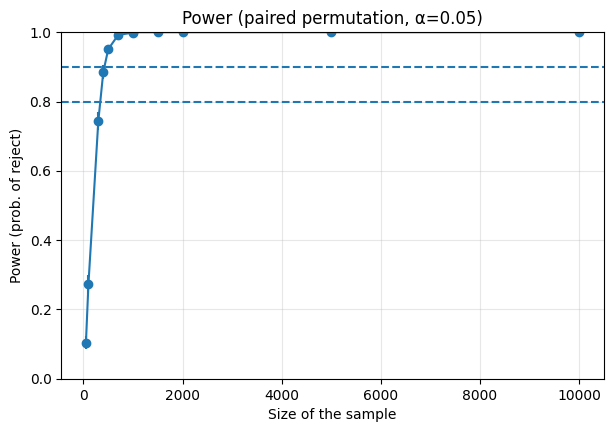

In [ ]:

plt.figure(figsize=(7,4.5))
# Barres d'erreur = IC95% Monte-Carlo (±1.96*SE)
plt.errorbar(N_arr, power_arr, yerr=1.96*SE_arr, fmt='o-')
plt.axhline(0.8, linestyle='--')  # repère 80%
plt.axhline(0.9, linestyle='--')  # repère 90%
plt.ylim(0, 1)
plt.xlabel("Size of the sample")
plt.ylabel("Power (prob. of reject)")

title = f"Power (paired permutation, α={str(0.05)})"
plt.title(title)
plt.grid(True, alpha=0.3)
plt.show()

# Replication

In [55]:
N = len(y)
all_idx = np.arange(N)

rest_idx = np.setdiff1d(all_idx, idx_1k, assume_unique=False)

In [ ]:
sss_r = StratifiedShuffleSplit(n_splits=2, test_size=10000, random_state=42)
_, idx_1k_r = next(sss_r.split(np.zeros(len(rest_idx)), y[rest_idx]))
test_idx= rest_idx[idx_1k_r]

texts_1k_r = np.array(texts)[test_idx]
y_1k_r     = y[test_idx]
assert len(set(idx_1k) & set(test_idx)) == 0, "Overlap detected!"

In [ ]:


def minimal_clean(text: str, max_words: int = 800) -> str:
    t = unicodedata.normalize("NFKC", str(text))  # unicode normalize
    t = html.unescape(t)                          # decode &amp; etc.
    t = _BR.sub(" ", t)                           # <br> -> space
    t = _HTML_TAG.sub(" ", t)                     # drop other tags
    t = _RATING.sub(" ", t)                       # remove 8/10 leaks
    t = _WS.sub(" ", t).strip()  
   
    return t
All_mini_vectors_r = model([minimal_clean(t) for t in list(texts_1k_r)])

In [126]:
def minimal_clean(text: str, max_words: int = 800) -> str:
    t = unicodedata.normalize("NFKC", str(text))  # unicode normalize
    t = html.unescape(t)                          # decode &amp; etc.
    t = _BR.sub(" ", t)                           # <br> -> space
    t = _HTML_TAG.sub(" ", t)                     # drop other tags
    t = _RATING.sub(" ", t)                       # remove 8/10 leaks
    t = _WS.sub(" ", t).strip()
    t = t.lower()  
   
    return t

In [134]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split([i for i in range(10000)], test_size=0.1, random_state=42)


In [128]:
tr_transformers = All_mini_vectors_r[X_train]
te_transformers = All_mini_vectors_r[X_test]


y_test = y_1k_r[X_test]

tr = list(X_train)
te = list(X_test)

tf_embed = TfidfEmbedder()
tf_vector_train = tf_embed.vec.fit_transform(texts_1k_r[tr])
tf_vector_test = tf_embed.transform(texts_1k_r[te])



model_A = LogisticRegression(max_iter=2000,solver="lbfgs").fit(tr_transformers,y_1k_r[tr])
model_B =  LogisticRegression(max_iter=2000,solver="liblinear").fit(tf_vector_train,y_1k_r[tr])

y_hat_A =  model_A.predict(te_transformers)
y_hat_B = model_B.predict(tf_vector_test)

correct_A = (y_hat_A == y_test)
correct_B = (y_hat_B == y_test)


In [129]:
obs, p, diffs = paired_perm_instance(correct_A,correct_B, n_perm=1000)

print(f"p_value : {p}")

p_value : 0.000999000999000999


In [130]:
end_min,end_max = bootstrap_ci_diff(correct_A, correct_B, B=1000000, seed=42)

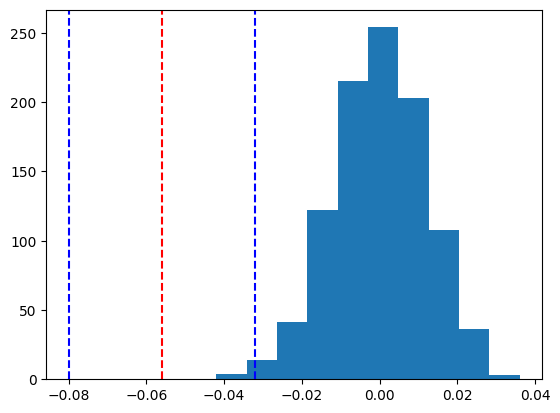

In [131]:
plt.hist(diffs)
plt.axvline(x=obs, color='r', linestyle='--', label ='observed difference')
plt.axvline(x=end_min, color='b', linestyle='--', label ='min')
plt.axvline(x=end_max, color='b', linestyle='--', label ='max')

# Analyze by features

In [ ]:
import re
import numpy as np

# --- small lexical lists ---
NEGATIONS = {
    "not","no","never","none","nobody","nothing","nowhere","neither","nor",
    "n't","dont","doesnt","didnt","cant","couldnt","shouldnt","won't","without","don't"
}
INTENSIFIERS = {
    "very","really","so","super","extremely","highly","incredibly",
    "too","quite","pretty","rather","totally","absolutely","completely","incredible",
    ""
}

# crude sentence splitter: counts ., !, ?
_SENT_RE = re.compile(r"[.!?]+")

# caps runs: 2+ uppercase letters (ASCII)
_CAPS_RUN_RE = re.compile(r"[A-Z]{2,}")

def build_feature_extractor(tfidf_vec, preproc_fn):
    
    analyzer = tfidf_vec.build_analyzer()
    vocab = tfidf_vec.vocabulary_               
    idf = tfidf_vec.idf_                         
  
    term_idf = {t: idf[i] for t, i in vocab.items()}

    def features_for_texts(raw_texts):
        n = len(raw_texts)
        len_tok   = np.zeros(n, dtype=np.int32)
        len_sent  = np.zeros(n, dtype=np.int32)
        mean_idf  = np.zeros(n, dtype=np.float32)
        oov_rate  = np.zeros(n, dtype=np.float32)
        neg_count = np.zeros(n, dtype=np.int32)
        intens    = np.zeros(n, dtype=np.int32)
        bangs     = np.zeros(n, dtype=np.int32)
        caps_runs = np.zeros(n, dtype=np.int32)

        for i, t in enumerate(raw_texts):
            t_clean = preproc_fn(t)
            toks = analyzer(t_clean)        
            T = len(toks)
            len_tok[i]  = T
            len_sent[i] = len(_SENT_RE.findall(t_clean))
            bangs[i]    = t_clean.count("!")
            caps_runs[i]= len(_CAPS_RUN_RE.findall(t))

            if T == 0:
                mean_idf[i] = 0.0
                oov_rate[i] = 1.0
                neg_count[i] = 0
                intens[i] = 0
                continue

            in_vocab_idfs = []
            oov = 0
            for w in toks:
                if w in term_idf:
                    in_vocab_idfs.append(term_idf[w])
                else:
                    oov += 1
            oov_rate[i] = oov / T
            mean_idf[i] = float(np.mean(in_vocab_idfs)) if in_vocab_idfs else 0.0

            tok_lower = [w.lower() for w in toks]
            neg_count[i] = sum(1 for w in tok_lower if w in NEGATIONS)
            intens[i]    = sum(1 for w in tok_lower if w in INTENSIFIERS)

        return {
            "len_tok":   len_tok,
            "len_sent":  len_sent,
            "mean_idf":  mean_idf,
            "oov_rate":  oov_rate,
            "neg_count": neg_count,
            "intens":    intens,
            "bangs":     bangs,
        }
    return features_for_texts


In [ ]:

feat_fn = build_feature_extractor(tf_embed.vec, minimal_clean)


F = feat_fn(texts_1k_r[X_test]) 


idx_A_only = np.where((correct_A==1) & (correct_B==0))[0]  
idx_B_only = np.where((correct_A==0) & (correct_B==1))[0]  

def bin_by_quantiles(x, q=(1/3,2/3)):
    q1,q2 = np.quantile(x, q)
    return np.digitize(x, [q1,q2]) 

bins_len = bin_by_quantiles(F["len_tok"])
for b,name in enumerate(["short","medium","long"]):
    m = (bins_len==b)
    Awin = int(np.sum(m & ((correct_A==1)&(correct_B==0))))
    Bwin = int(np.sum(m & ((correct_A==0)&(correct_B==1))))
    print(f"{name:6}  SBERT-only={Awin:4d}  TFIDF-only={Bwin:4d}  Δ={Awin-Bwin:+d}")


short   SBERT-only=  14  TFIDF-only=  34  Δ=-20
medium  SBERT-only=  15  TFIDF-only=  33  Δ=-18
long    SBERT-only=  20  TFIDF-only=  38  Δ=-18


In [ ]:
import pandas as pd

from statsmodels.stats.multitest import multipletests
from scipy import stats

idx_A_only = np.where((correct_A==1) & (correct_B==0))[0]
idx_B_only = np.where((correct_A==0) & (correct_B==1))[0]
idx_disc = np.r_[idx_A_only, idx_B_only]
y = np.r_[np.ones(len(idx_A_only)), np.zeros(len(idx_B_only))]


cols = ["len_tok","len_sent","mean_idf","oov_rate","neg_count","intens","bangs"]
Xdf = pd.DataFrame({k: F[k][idx_disc] for k in cols})

---
rows = []
for c in cols:
    a = Xdf.loc[:len(idx_A_only)-1, c].to_numpy() 
    b = Xdf.loc[len(idx_A_only):, c].to_numpy()   


    t, p_t = stats.ttest_ind(a, b, equal_var=False)
  
    s1, s2 = a.var(ddof=1), b.var(ddof=1)
    n1, n2 = len(a), len(b)
    sd_p = np.sqrt(((s1/n1) + (s2/n2)) * (n1*n2/(n1+n2))) 
    d = (a.mean() - b.mean()) / (np.sqrt((s1+s2)/2) + 1e-9)

    u, p_mw = stats.mannwhitneyu(a, b, alternative="two-sided")
    rrb = 1 - 2*u/(n1*n2) 

    rows.append((c, a.mean(), b.mean(), d, t, p_t, rrb, p_mw))

tbl = pd.DataFrame(rows, columns=["feature","mean_SBERT","mean_TFIDF",
                                  "t","p_t","rank_biserial","p_mw"])

tbl["p_adj"] = multipletests(tbl["p_t"], method="fdr_bh")[1]
tbl.sort_values("p_adj", inplace=True)
print(tbl)

In [152]:
Xdf

,len_tok,len_sent,mean_idf,oov_rate,neg_count,intens,bangs,caps_runs
0,279,9,5.029482,0.265233,2,2,0,0
1,391,17,4.579808,0.184143,1,6,0,1
2,401,7,4.934462,0.291771,2,1,10,0
3,603,13,4.993753,0.265340,0,3,0,1
4,1117,36,4.801936,0.246195,5,11,1,8
...,...,...,...,...,...,...,...,...
149,725,17,4.468605,0.213793,9,2,0,0
150,681,20,4.539519,0.227606,4,3,0,0
151,219,4,4.580695,0.223744,2,1,0,0
152,245,7,4.496560,0.212245,1,4,2,1


In [161]:
tbl

,feature,mean_SBERT,mean_TFIDF,cohen_d,t,p_t,rank_biserial,p_mw,p_adj
2,mean_idf,4.835711,4.741173,0.353302,1.975227,0.051706,-0.180175,0.072490,0.180970
3,oov_rate,0.264950,0.245450,0.377894,2.069365,0.042088,-0.162682,0.104916,0.180970
0,len_tok,447.285714,415.000000,0.107922,0.628392,0.531219,-0.108066,0.281706,0.743707
4,neg_count,2.612245,2.314286,0.127060,0.734578,0.464427,-0.096016,0.329718,0.743707
6,bangs,0.959184,0.590476,0.155072,0.790749,0.432581,0.029155,0.721941,0.743707
5,intens,3.183673,3.047619,0.050948,0.286519,0.775204,-0.000777,0.995306,0.904404
1,len_sent,12.346939,12.209524,0.015429,0.089723,0.928693,-0.022546,0.823205,0.928693
